In [7]:
from sklearn.datasets import fetch_openml
import numpy as np
import cv2
from sklearn.svm import SVC

mnist = fetch_openml('mnist_784', version=1)
images = mnist.data.to_numpy().reshape(-1, 28, 28)
labels = mnist.target.astype(int)

def make_plate(images, labels, num_digits=4):
    idxs = np.random.choice(len(images), num_digits, replace=False)
    plate = np.hstack([images[i] for i in idxs])
    plate_labels = [labels[i] for i in idxs]
    return plate, plate_labels

def random_affine(img):
    rows, cols = img.shape
    pts1 = np.float32([[0,0], [cols-1,0], [0,rows-1]])
    pts2 = np.float32([[np.random.randint(0,5), np.random.randint(0,5)],
                       [cols-1+np.random.randint(-5,5), np.random.randint(0,5)],
                       [np.random.randint(0,5), rows-1+np.random.randint(-5,5)]])
    M = cv2.getAffineTransform(pts1, pts2)
    img_uint8 = img.astype(np.uint8)
    dst = cv2.warpAffine(img_uint8, M, (cols, rows))
    return dst

def split_plate(plate, num_digits=4):
    digits = []
    for i in range(num_digits):
        digit_img = plate[:, i*28:(i+1)*28]
        digits.append(digit_img)
    return digits

plate, plate_labels = make_plate(images, labels)
plate_img_affine = random_affine(plate)

X_train = images[:10000].reshape(-1, 784)
y_train = labels[:10000]

clf = SVC()
clf.fit(X_train, y_train)

digits_imgs = split_plate(plate_img_affine)

preds = []
for digit_img in digits_imgs:
    pred = clf.predict(digit_img.reshape(1, -1))
    preds.append(pred[0])
print(f"Ground truth:   {plate_labels}")
print(f'Predictions: {preds}')

Ground truth:   [np.int64(2), np.int64(8), np.int64(1), np.int64(6)]
Predictions: [np.int64(2), np.int64(0), np.int64(1), np.int64(4)]


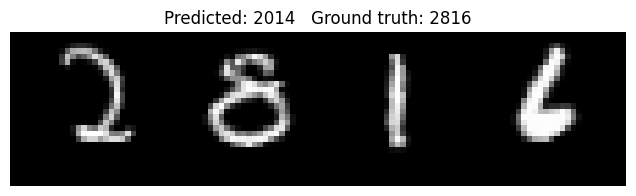

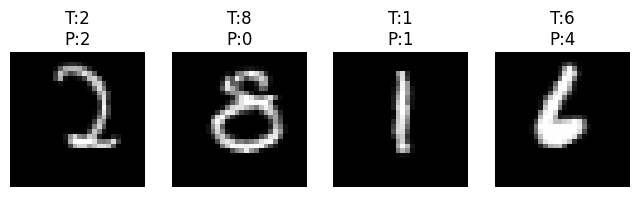

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 2))
plt.imshow(plate_img_affine, cmap='gray')
plt.axis('off')
plt.title(f"Predicted: {''.join(str(d) for d in preds)}   Ground truth: {''.join(str(d) for d in plate_labels)}")
plt.show()

fig, axes = plt.subplots(1, len(digits_imgs), figsize=(8,2))
for i, ax in enumerate(axes):
    ax.imshow(digits_imgs[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f"T:{plate_labels[i]}\nP:{preds[i]}")
plt.show()

Plate 1
  Ground truth: [np.int64(6), np.int64(1), np.int64(3), np.int64(3)]
  Predictions: [np.int64(5), np.int64(1), np.int64(3), np.int64(3)]


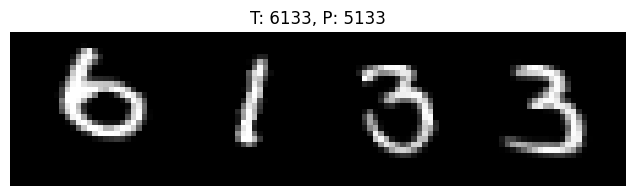

Plate 2
  Ground truth: [np.int64(3), np.int64(1), np.int64(2), np.int64(8)]
  Predictions: [np.int64(2), np.int64(7), np.int64(7), np.int64(2)]


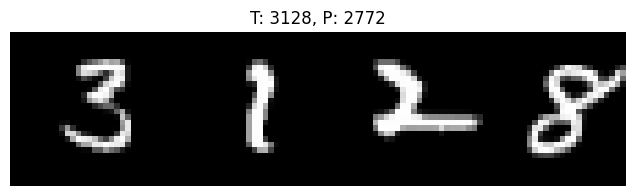

Plate 3
  Ground truth: [np.int64(4), np.int64(8), np.int64(7), np.int64(4)]
  Predictions: [np.int64(4), np.int64(9), np.int64(7), np.int64(4)]


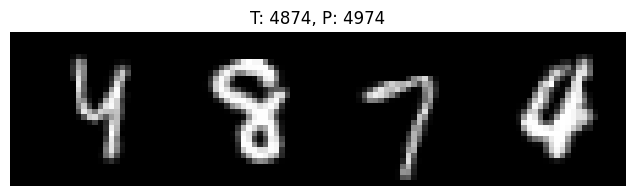

===
Digit accuracy: 56.75% (227/400)
Plate accuracy: 20.00% (20/100)


In [9]:
# Evaluate on multiple random plates
num_plates = 100
num_digits = 4

total_digits = 0
correct_digits = 0
total_plates = 0
correct_plates = 0

for i in range(num_plates):
    plate, plate_labels = make_plate(images, labels)
    plate_img_affine = random_affine(plate)
    digits_imgs = split_plate(plate_img_affine, num_digits=num_digits)
    
    preds = []
    for digit_img in digits_imgs:
        pred = clf.predict(digit_img.reshape(1, -1))
        preds.append(pred[0])
    
    # Update digit accuracy
    total_digits += num_digits
    correct_digits += sum(int(p == t) for p, t in zip(preds, plate_labels))
    # Update plate accuracy
    total_plates += 1
    if all(p == t for p, t in zip(preds, plate_labels)):
        correct_plates += 1
    
    # Optionally: Show the first few plates visually for debugging
    if i < 3:
        print(f"Plate {i+1}")
        print(f"  Ground truth: {plate_labels}")
        print(f"  Predictions: {preds}")
        plt.figure(figsize=(8,2))
        plt.imshow(plate_img_affine, cmap='gray')
        plt.axis('off')
        plt.title(f"T: {''.join(str(x) for x in plate_labels)}, P: {''.join(str(x) for x in preds)}")
        plt.show()

print("===")
print(f"Digit accuracy: {correct_digits/total_digits:.2%} ({correct_digits}/{total_digits})")
print(f"Plate accuracy: {correct_plates/total_plates:.2%} ({correct_plates}/{total_plates})")